Мы хотим определить, насколько каждый из методов чувствителен к выбору точки старта. Для этого сначала считается точка оптимума для первоначального графа. Далее граф немного меняется и считается новый оптимум, но за точку старта мы берем не free_flow_time, а старую посчитанную точку оптимума для первоначального графа. Так как граф изменился не слишком сильно, то предполагается, что новая точка оптимума изменилась также не сильно, следовательно, алгоритмы могут сойтись быстрее начиная с более близкой к оптимуму точки. Это мы и проверяем в данном эксперименте

In [1]:
import pandas as pd
import numpy as np
import data_handler as dh
import model as md
import time
import matplotlib.pyplot as plt
from matplotlib import rc
from multiprocessing import Pool
import pickle
pd.options.mode.chained_assignment = None 
import copy
from scipy.stats import norm
import random
import pickle

/home/denis/hdd/Gasnikov/env/lib/python3.6/site-packages/graph_tool/draw/cairo_draw.py:1463: RuntimeWarning: Error importing Gtk module: No module named 'gi'; GTK+ drawing will not work.
  warnings.warn(msg, RuntimeWarning)


In [2]:
import importlib
importlib.reload(dh)
importlib.reload(md)

<module 'model' from '/home/denis/hdd/Gasnikov/TransportNet/Stable Dynamic & Beckman/model.py'>

In [3]:
import numba
numba.__version__

'0.49.0'

In [4]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)
from platform import python_version
print('python', python_version())
print('numpy', np.__version__)
print('pandas', pd.__version__)
import graph_tool
print('graph_tool', graph_tool.__version__)

/home/denis/hdd/Gasnikov/env/bin/python3
3.6.9 (default, Dec  8 2021, 21:08:43) 
[GCC 8.4.0]
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
python 3.6.9
numpy 1.19.1
pandas 1.1.0
graph_tool 2.30 (commit 087aace0, Mon Mar 23 08:58:49 2020 +0000)


# Beckmann model

parameter $\mu = 0.25$

In [5]:
beckmann_save = 'beckmann_results/'
net_name = 'Anaheim_net.tntp'
trips_name = 'Anaheim_trips.tntp'

In [6]:
net_name = 'Anaheim_net.tntp'
trips_name = 'Anaheim_trips.tntp'

handler = dh.DataHandler()
graph_data = handler.GetGraphData(net_name, columns = ['init_node', 'term_node', 'capacity', 'free_flow_time'])
graph_correspondences, total_od_flow = handler.GetGraphCorrespondences(trips_name)

model = md.Model(graph_data, graph_correspondences, 
                    total_od_flow, mu = 0.25, rho = 0.15)

In [7]:
epsilon = 10 # fixed duality gap
max_iter = 10000 
# рассматриваем эти два солвера, так как они более всех чувствительны к выбору точки старта
solvers = ['wda', 'ustm']

In [9]:
# Сначала находится точка оптимума для изначального графа
# Для чистоты эксперимента каждый солвер ищет свою точку оптимума, но на самом деле они очевидно очень близки

'''
initial_results = {}
for solver in solvers:
    solver_kwargs = {'eps_abs': epsilon,
                     'max_iter': max_iter, 'stop_crit': 'dual_gap',
                     'verbose' : True, 'verbose_step': 4000, 'save_history' : True}
    tic = time.time()
    initial_results[solver] = model.find_equilibrium(solver_name = solver, composite = True, solver_kwargs = solver_kwargs)
    toc = time.time()
    
with open("initial_results.txt", "wb") as fp:   #Pickling
    pickle.dump(initial_results, fp)
'''

# Результаты уже посчитаны, вы можете загрузить их с помощью pickle:
with open("initial_results.txt", "rb") as fp:   # Unpickling
    initial_results = pickle.load(fp)

In [11]:
def node_roads(graph_table, node):
    return set(graph_table[np.array(graph_table['term_node'] == node) + np.array(graph_table['init_node'] == node)].index)


def edge_neighbours(graph_table, edge_num):
    init_node = graph_table.loc[edge_num]['init_node']
    term_node = graph_table.loc[edge_num]['term_node']
    res = node_roads(graph_table, init_node)
    res.update(node_roads(graph_table, term_node))
    return res

def n_neighbour_edges(graph_table, node, depth):
    neighbours = node_roads(graph_table, node)
    for i in range(depth - 1):
        new_neighbours = neighbours.copy()
        for curr_edge in neighbours:
            new_neighbours.update(edge_neighbours(graph_table, curr_edge))
        neighbours = new_neighbours
    return neighbours


def normal_distribution_noise(node, depth, std_percentage_capacity, std_percentage_flow):
    '''
    Эта функция локально изменяет граф (capacity и free flow time), учитывая глубину изменения depth, 
    по нормальному закону распределния с матожиданием 0 и дисперсией std_percentage_capacity * capacity, 
    где capacity это начальная проходимость, а std_percentage_capacity меняется в процессе эксперимента 
    '''
    graph_data_copy = copy.deepcopy(graph_data)
    graph_correspondences_copy = copy.deepcopy(graph_correspondences)
    graph_capacity = graph_data_copy['graph_table']['capacity']
    graph_free_flow_time = graph_data_copy['graph_table']['free_flow_time']

    graph_table = graph_data['graph_table']
    neighbour_edges = n_neighbour_edges(graph_table, node, depth)

    for index in neighbour_edges:
        capacity = graph_capacity[index]
        std = capacity * std_percentage_capacity
        noise = norm.rvs(0, std)
        graph_capacity[index] = max(capacity + noise, 0.1)

        flow = graph_free_flow_time[index]
        std = flow * std_percentage_flow
        noise = norm.rvs(0, std)
        graph_free_flow_time[index] = max(flow + noise, 0.1)
    return graph_data_copy, graph_correspondences_copy 

def find_equilibrium(kwargs):
    '''
    Функция нахождения равновесия. Туда мы передаем граф, солвер, точку старта 
    '''
    new_model = md.Model(kwargs['graph_data'], kwargs['graph_correspondences'], 
                    total_od_flow, mu = 0.25, rho = 0.15)
    tic_new = time.time()
    result = new_model.find_equilibrium(**(kwargs['kwargs_for_equilibr']))
    toc_new = time.time()
    kwargs['kwargs_for_equilibr']['t_start'] = None
    tic_initial = time.time()
    result_initial = new_model.find_equilibrium(**(kwargs['kwargs_for_equilibr']))
    toc_initial = time.time()
    return {'args': kwargs, 'result': result, 'result_initial': result_initial, 'elapsed_time_new': toc_new - tic_new, 'elapsed_time_initial': toc_initial - tic_initial}

Мы хотим узнать, как зависит процент изменения графа на скорость сходимости 

In [14]:
variance_list = [0.01, 0.03, 0.05, 0.07, 0.1, 0.15, 0.2, 0.25, 0.3] # процент изменения графа в долях
amount_of_notes = 10 # Для каждого процентного изменения первоначального графа 
                     #случайно выбираются amount_of_notes нод
amount_exp_for_one_node = 5 # Для каждой ноды проводится по amount_exp_for_one_node итераций нахождения оптимума
depth = 2 # Фиксируем глубину локального изменения дорог

In [54]:
### !!! Результаты уже посчитаны, это можно не запускать

# Составляем список всех параметров для каждой итерации эксперимента, для дальнейшего распараллеливания 
list_kwargs = []
for variance_percentage in variance_list:
    for i in range(amount_of_notes):
        node = random.randint(1, graph_data['nodes number'])
        for i in range(amount_exp_for_one_node):
            new_graph_data, new_graph_correspondences = normal_distribution_noise(node, depth, variance_percentage, variance_percentage)
            for solver_name in solvers:
                kwargs = {}
                kwargs_for_equilibr = {}
                solver_kwargs = {'eps_abs': epsilon,
                                 'max_iter': max_iter, 'stop_crit': 'dual_gap',
                                 'verbose' : False, 'verbose_step': 4000, 'save_history' : False}
                kwargs_for_equilibr['solver_kwargs'] = solver_kwargs
                kwargs_for_equilibr['solver_name'] = solver_name
                kwargs_for_equilibr['t_start'] = result_initial[solver_name]['times']
                kwargs['kwargs_for_equilibr'] = kwargs_for_equilibr.copy()
                kwargs['variance_percentage'] = variance_percentage
                kwargs['node'] = node
                kwargs['node_i'] = i
                kwargs['graph_data'] = new_graph_data
                kwargs['graph_correspondences'] = new_graph_correspondences
                list_kwargs.append(kwargs)

In [14]:
# Кладем в пулл процессов
def find_eq_for_list(arg_list):
    pool = Pool(processes=len(arg_list))
    return pool.map(find_equilibrium, arg_list)

In [16]:
# Сам эксперимент 
'''
local_results = find_eq_for_list(list_kwargs)

with open("local_results.txt", "wb") as fp:   #Pickling
    pickle.dump(local_results, fp)
'''

# Результаты уже посчитаны, вы можете загрузить их с помощью pickle:
with open("local_results.txt", "rb") as fp:   # Unpickling
    local_results = pickle.load(fp)

#### Анализ результатов

In [19]:
'''
with open("local_results.txt", "rb") as fp:   # Unpickling
    local_results = pickle.load(fp)
with open("initial_results.txt", "rb") as fp:   # Unpickling
    initial_results = pickle.load(fp)
'''

In [17]:
# считаем относительный показатель улучшения алгоритма подсчета новой точки оптимума начиная со старой точки
# относительно такого же подсчета но начиная с точки free flow time
average_result = []
for i in range(len(variance_list) * amount_of_notes * amount_exp_for_one_node * len(solvers)):
    
    average_result.append(local_results[i]['result']['iter_num']/local_results[i]['result_initial']['iter_num'])

In [18]:
average_result_var = {}
step = len(solvers)
for index_solver, solver_name in enumerate(solvers):
    start = index_solver
    solver_result = average_result[start::step]
    average_result_var[solver_name] = []
    for i in range(len(variance_list)):
        start_for_node = i * amount_of_notes * amount_exp_for_one_node
        finish_for_node = start_for_node + amount_of_notes * amount_exp_for_one_node
        average_result_var[solver_name].append(np.mean(solver_result[start_for_node:finish_for_node]))

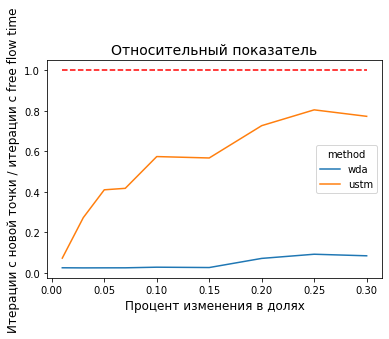

In [26]:
for method in solvers:
    plt.plot(variance_list, average_result_var[method], label = method)
plt.plot(variance_list, np.ones(len(variance_list)), color = 'r', linestyle = '--')
plt.legend(title = 'method')
plt.title("Относительный показатель", fontsize = 14)
plt.xlabel("Процент изменения в долях", fontsize = 12)
plt.ylabel("Итерации с новой точки / итерации с free flow time", fontsize = 12)
#plt.savefig('relatively_iteration_for_variance.png', dpi=300)
plt.show()

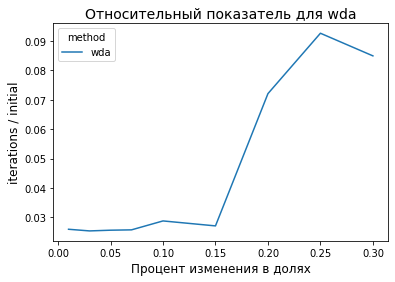

In [27]:
# Отдельно для wda
plt.plot(variance_list, average_result_var['wda'], label = 'wda')
#plt.plot(variance_list, np.ones(len(variance_list)), color = 'r', linestyle = '--')
plt.legend(title = 'method')
plt.title("Относительный показатель для wda", fontsize = 14)
plt.xlabel("Процент изменения в долях", fontsize = 12)
plt.ylabel("iterations / initial", fontsize = 12)
#plt.savefig('relatively_iteration_for_variance_wda.png', dpi=300)
plt.show()

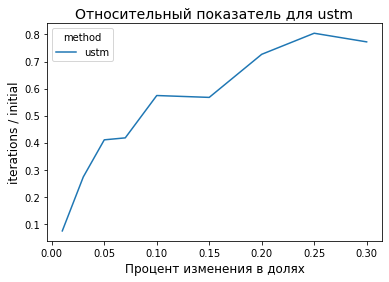

In [28]:
# Отдельно для ustm
plt.plot(variance_list, average_result_var['ustm'], label = 'ustm')
#plt.plot(variance_list, np.ones(len(variance_list)), color = 'r', linestyle = '--')
plt.legend(title = 'method')
plt.title("Относительный показатель для ustm", fontsize = 14)
plt.xlabel("Процент изменения в долях", fontsize = 12)
plt.ylabel("iterations / initial", fontsize = 12)
#plt.savefig('relatively_iteration_for_variance_ustm.png', dpi=300)
plt.show()

In [29]:
# А теперь посчитаем не относительный показатель, а количественный
average_result_not_rel = []
for i in range(len(variance_list) * amount_of_notes * amount_exp_for_one_node * len(solvers)):
    
    average_result_not_rel.append(local_results[i]['result']['iter_num'])

In [30]:
average_result_var_not_rel = {}
step = len(solvers)
for index_solver, solver_name in enumerate(solvers):
    start = index_solver
    solver_result = average_result_not_rel[start::step]
    average_result_var_not_rel[solver_name] = []
    for i in range(len(variance_list)):
        start_for_node = i * amount_of_notes * amount_exp_for_one_node
        finish_for_node = start_for_node + amount_of_notes * amount_exp_for_one_node
        average_result_var_not_rel[solver_name].append(np.mean(solver_result[start_for_node:finish_for_node]))

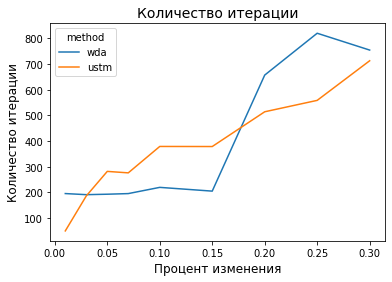

In [32]:
for method in solvers:
    plt.plot(variance_list, average_result_var_not_rel[method], label = method)
#plt.plot(variance_list, np.ones(len(variance_list)), color = 'r', linestyle = '--')
plt.legend(title = 'method')
plt.title("Количество итерации", fontsize = 14)
plt.xlabel("Процент изменения", fontsize = 12)
plt.ylabel("Количество итерации", fontsize = 12)
#plt.savefig('not_relatively_iteration_for_variance.png', dpi=300)
plt.show()

А теперь мы проводим такой же эксперимент, но уже хотим варьировать глубину локального изменения графа, 
то есть мы варьируем величину depth, а variance_percentage оставляем равный 10%

In [35]:
# for depth
depth_list = [1, 2, 3, 4, 5]
amount_of_notes = 10
amount_exp_for_one_node = 5
variance_percentage = 0.1

In [19]:
#!!! Можно не запускать, результаты можно загрузить далее
list_kwargs = []
for depth in depth_list:
    for i in range(amount_of_notes):
        node = random.randint(1, graph_data['nodes number'])
        for i in range(amount_exp_for_one_node):
            new_graph_data, new_graph_correspondences = normal_distribution_noise(node, depth, variance_percentage, variance_percentage)
            for solver_name in solvers:
                kwargs = {}
                kwargs_for_equilibr = {}
                solver_kwargs = {'eps_abs': epsilon,
                                 'max_iter': max_iter, 'stop_crit': 'dual_gap',
                                 'verbose' : False, 'verbose_step': 4000, 'save_history' : False}
                kwargs_for_equilibr['solver_kwargs'] = solver_kwargs
                kwargs_for_equilibr['solver_name'] = solver_name
                kwargs_for_equilibr['t_start'] = result_initial[solver_name]['times']
                kwargs['kwargs_for_equilibr'] = kwargs_for_equilibr.copy()
                kwargs['depth'] = depth
                kwargs['node'] = node
                kwargs['node_i'] = i
                kwargs['graph_data'] = new_graph_data
                kwargs['graph_correspondences'] = new_graph_correspondences
                list_kwargs.append(kwargs)

In [36]:
'''
local_results_depth = find_eq_for_list(list_kwargs)

with open("local_results_depth.txt", "rb") as fp:   # Unpickling
    local_results_depth = pickle.dump(fp)
'''

# загружаем результаты 
with open("local_results_depth.txt", "rb") as fp:   # Unpickling
    local_results_depth = pickle.load(fp)

In [37]:
average_result_depth = []
for i in range(len(depth_list) * amount_of_notes * amount_exp_for_one_node * len(solvers)):
    
    average_result_depth.append(local_results_depth[i]['result']['iter_num']/local_results_depth[i]['result_initial']['iter_num'])

In [38]:
average_result_depth_ = {}
step = len(solvers)
for index_solver, solver_name in enumerate(solvers):
    start = index_solver
    solver_result = average_result_depth[start::step]
    average_result_depth_[solver_name] = []
    for i in range(len(depth_list)):
        start_for_node = i * amount_of_notes * amount_exp_for_one_node
        finish_for_node = start_for_node + amount_of_notes * amount_exp_for_one_node
        average_result_depth_[solver_name].append(np.mean(solver_result[start_for_node:finish_for_node]))

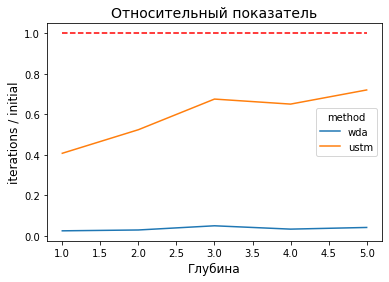

In [39]:
for method in solvers:
    plt.plot(depth_list, average_result_depth_[method], label = method)
plt.plot(depth_list, np.ones(len(depth_list)), color = 'r', linestyle = '--')
plt.legend(title = 'method')
plt.title("Относительный показатель", fontsize = 14)
plt.xlabel("Глубина", fontsize = 12)
plt.ylabel("iterations / initial", fontsize = 12)
#plt.savefig('relatively_iteration_for_depth.png', dpi=300)
plt.show()

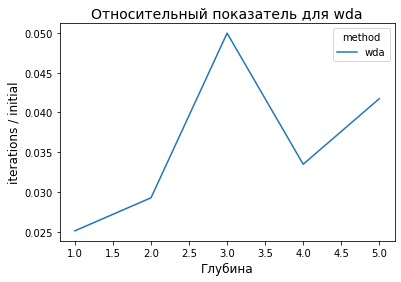

In [40]:
plt.plot(depth_list, average_result_depth_['wda'], label = 'wda')
#plt.plot(depth_list, np.ones(len(depth_list)), color = 'r', linestyle = '--')
plt.legend(title = 'method')
plt.title("Относительный показатель для wda", fontsize = 14)
plt.xlabel("Глубина", fontsize = 12)
plt.ylabel("iterations / initial", fontsize = 12)
#plt.savefig('relatively_iteration_for_depth_wda.png', dpi=300)
plt.show()

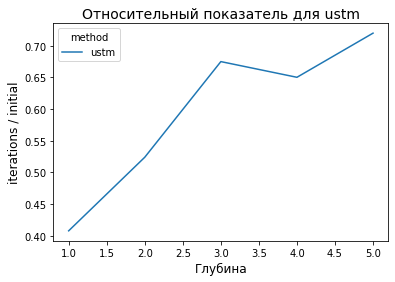

In [41]:
plt.plot(depth_list, average_result_depth_['ustm'], label = 'ustm')
#plt.plot(depth_list, np.ones(len(depth_list)), color = 'r', linestyle = '--')
plt.legend(title = 'method')
plt.title("Относительный показатель для ustm", fontsize = 14)
plt.xlabel("Глубина", fontsize = 12)
plt.ylabel("iterations / initial", fontsize = 12)
#plt.savefig('relatively_iteration_for_depth_ustm.png', dpi=300)
plt.show()

Далее считаем количественный результат, не относительный

In [42]:
average_result_depth_not_rel = []
for i in range(len(depth_list) * amount_of_notes * amount_exp_for_one_node * len(solvers)):
    
    average_result_depth_not_rel.append(local_results[i]['result']['iter_num'])

In [43]:
average_result_depth_var_not_rel = {}
step = len(solvers)
for index_solver, solver_name in enumerate(solvers):
    start = index_solver
    solver_result = average_result_depth_not_rel[start::step]
    average_result_depth_var_not_rel[solver_name] = []
    for i in range(len(depth_list)):
        start_for_node = i * amount_of_notes * amount_exp_for_one_node
        finish_for_node = start_for_node + amount_of_notes * amount_exp_for_one_node
        average_result_depth_var_not_rel[solver_name].append(np.mean(solver_result[start_for_node:finish_for_node]))

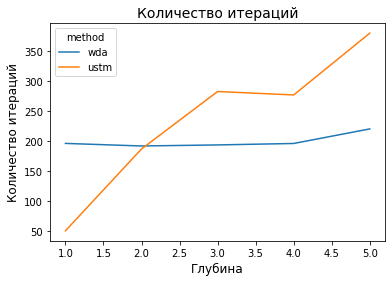

In [44]:
for method in solvers:
    plt.plot(depth_list, average_result_depth_var_not_rel[method], label = method)
#plt.plot(variance_list, np.ones(len(variance_list)), color = 'r', linestyle = '--')
plt.legend(title = 'method')
plt.title("Количество итераций", fontsize = 14)
plt.xlabel("Глубина", fontsize = 12)
plt.ylabel("Количество итераций", fontsize = 12)
#plt.savefig('not_relatively_iteration_for_depth.png', dpi=300)
plt.show()